## Visualization

In [6]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(glue); library(lubridate)
    library(scales);library(reshape2); library(wmf);library(RColorBrewer);
})

### Editors

In [7]:
file <- "metrics/metrics.tsv"
contributor <- read.csv(file,sep = '\t')
contributor$month <- as.Date(contributor$month, format = "%Y-%m-%d")

In [8]:
tail(contributor,20)

,month,active_editors,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile.heavy_wiki_active_editors,mobile.heavy_wiki_edits,mobile.heavy_wiki_new_editor_retention,mobile.heavy_wiki_nonbot_edits,⋯,net_new_Wikipedia_articles,net_new_content_pages,new_active_editors,new_editor_retention,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits
,<date>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,⋯,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>
214,2018-09-01,82328,20109,2070328,0.04832000,2070326,3863,846503,0.05068545,437457,⋯,185644,1635067,18270,0.05681354,11062745,64058,0.09307746,38605571,830428,17786725
215,2018-10-01,82405,19891,1979771,NA,1979769,3825,957794,0.05048498,433507,⋯,191087,2101982,16518,0.06641143,10790092,65887,0.09818926,43486666,582738,23073044
216,2018-11-01,82235,20008,2015177,0.04200000,2015175,3639,1150793,0.04332890,456985,⋯,192340,2268787,15506,0.06874217,11038500,66729,0.09374739,44376013,586129,23896534
217,2018-12-01,80796,20359,2067577,0.04100000,2067577,4046,1125381,0.04704514,488735,⋯,186233,2128146,14662,0.07207374,10991655,66134,0.08547773,41988394,546299,21418466
218,2019-01-01,86782,21367,2434941,0.03839281,2434941,4228,988233,0.04335825,512674,⋯,200366,1938938,17096,0.05423185,12143464,69686,0.08130336,46312638,580719,23213770
219,2019-02-01,82554,19743,2241877,0.04347225,2241875,3901,966696,0.04547853,438437,⋯,195100,1455387,16335,0.05465257,10952758,66219,0.07375803,44135189,531456,22667003
220,2019-03-01,87711,21679,2294512,0.04577446,2294512,4252,996968,0.04395047,465084,⋯,216257,1587804,17738,0.07326752,11748062,69973,0.06309033,49434627,542547,28490299
221,2019-04-01,84358,19941,2053568,0.04010374,2052287,3996,1412904,0.04376658,414992,⋯,268254,1782113,15535,0.06862974,10955991,68823,0.05577760,51252861,616226,30126989
222,2019-05-01,90211,20841,2273855,0.04296635,2272975,4195,1384712,0.04962526,460884,⋯,189506,1978179,19323,0.06760472,11728361,70888,0.05939815,46847183,702372,23578489


In [4]:
editors_fy <- contributor %>% 
     select(month,active_editors,new_active_editors,returning_active_editors) %>%
     filter(month >= '2017-07-01') %>%
    # filter(month < '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2017-07-01' & month < '2018-07-01', 'FY 2017/18', ifelse(month <'2017-07-01','FY 2016/17',ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

editors_fy$MonthN = factor(editors_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

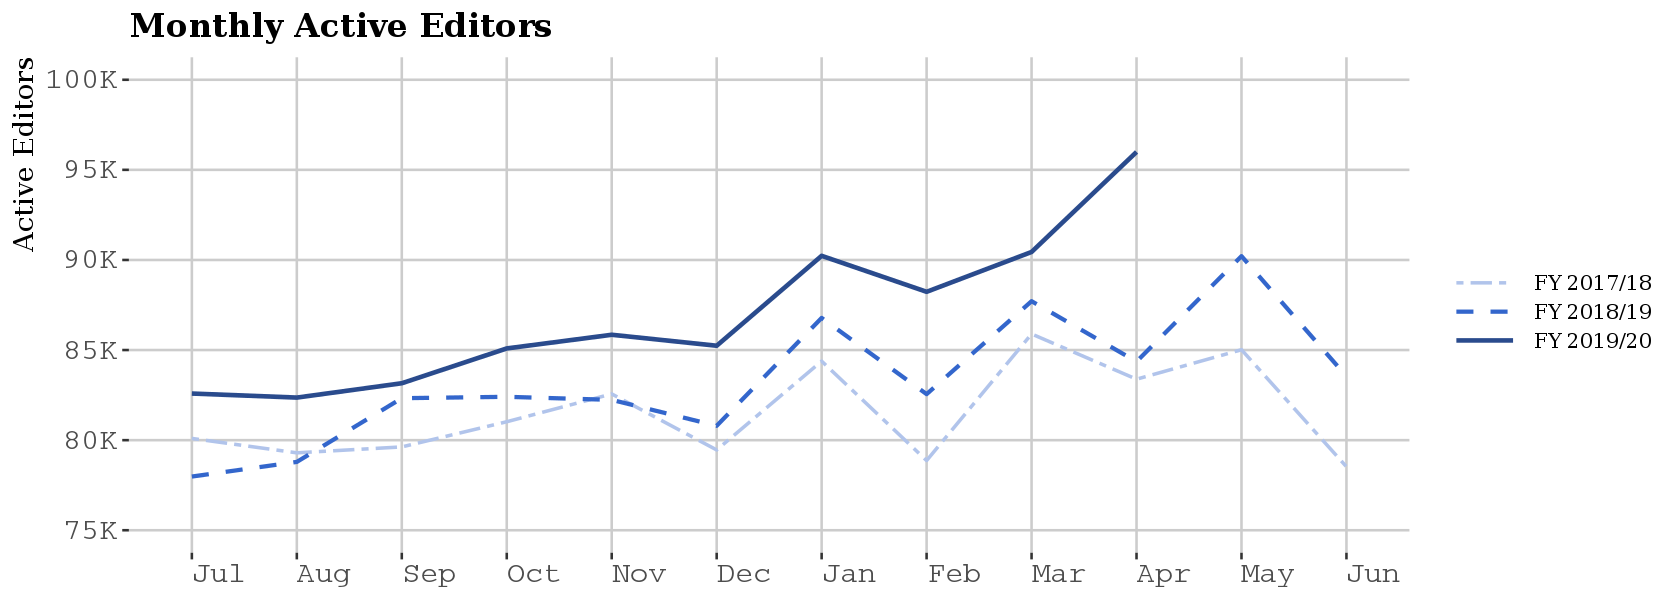

In [6]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(editors_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = active_editors, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#b1c4eb", "FY 2018/19" = "#3366cc","FY 2019/20" = "#2a4b8d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = editors_fy$MonthN, labels = editors_fy$Month) +
    scale_y_continuous("Active Editors", labels = polloi::compress,limits = c(75E3, 100E3)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Active Editors") 

p1


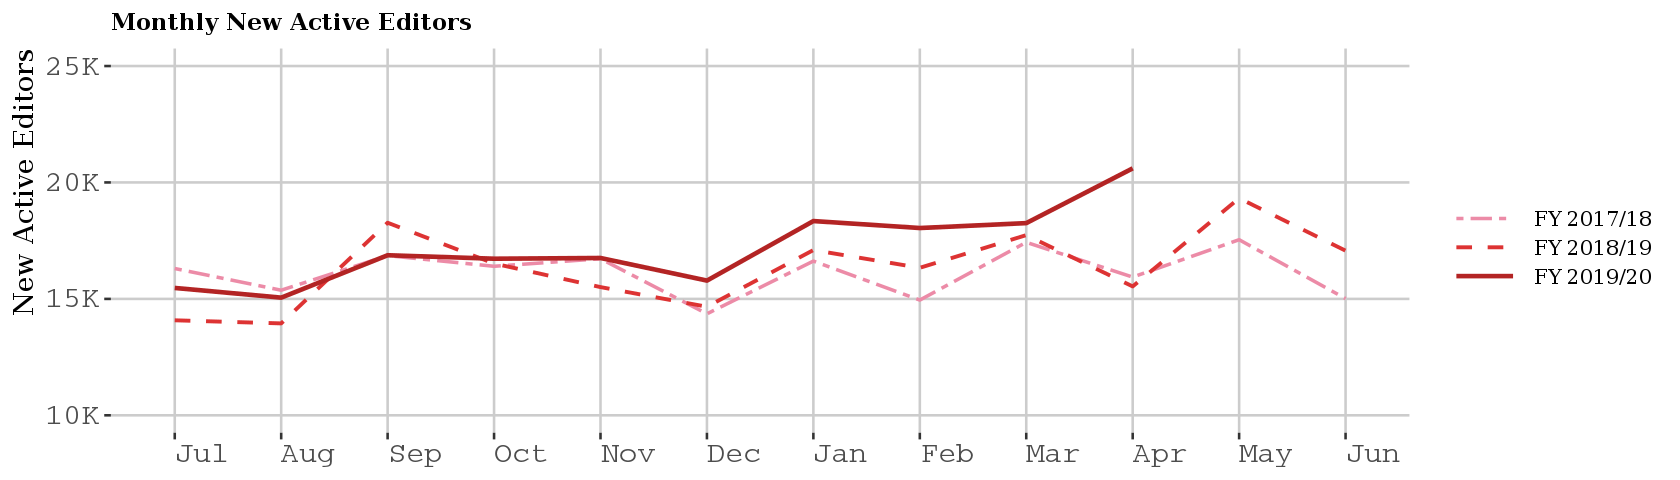

In [7]:
options(repr.plot.width = 14, repr.plot.height = 4)

p2 <- ggplot(editors_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = new_active_editors, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=15500 , size = 4, color = '#b32424') +
    #geom_text(aes(x =01, y=15000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1,1.1,1.3,2)) +
    scale_color_manual(values = c("FY 2017/18" = "#ec8ba7", "FY 2018/19" = "#dd3333","FY 2019/20" = "#b32424")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete("Month",
                      breaks = editors_fy$MonthN, 
                     labels = editors_fy$Month) +
    scale_y_continuous("New Active Editors",labels = polloi::compress,limits = c(10E3, 25E3)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.title.x=element_blank(),axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 14,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size = 11),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly New Active Editors") 

p2

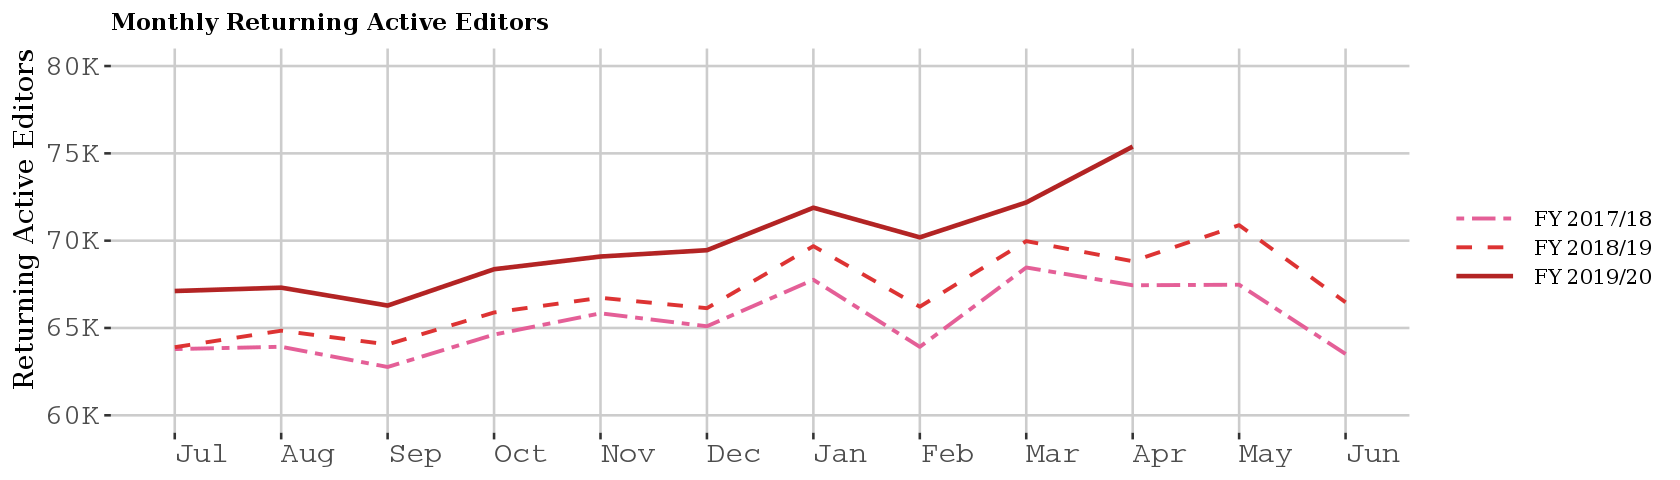

In [9]:
options(repr.plot.width = 14, repr.plot.height = 4)

p3 <- ggplot(editors_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = returning_active_editors, group=fiscal_year, color = fiscal_year,linetype = fiscal_year,size=fiscal_year)) +
    #geom_point(x=01, y=67100 , size = 4, color = '#b32424') +
    #geom_text(aes(x =01, y=67800, label="July 2019"),hjust=0, vjust=0, size= 5) + 
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +
    scale_color_manual(values = c("FY 2017/18" = "#e45f97", "FY 2018/19" = "#dd3333","FY 2019/20" = "#b32424")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete("Month",breaks = editors_fy$MonthN, labels = editors_fy$Month) +
    scale_y_continuous("Returning Active Editors", labels = polloi::compress,limits = c(60E3, 80E3)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
     theme(axis.title.x=element_blank(),axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 14,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size = 11),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
           legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Returning Active Editors")

p3

## Edits

In [10]:
edit_fy <- contributor %>% 
     select(month,total_edits,uploads,wikidata_edits) %>%
     mutate(nonwikidata = total_edits - wikidata_edits)  %>%
     filter(month >= '2017-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2017-07-01' & month < '2018-07-01', 'FY 2017/18', ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20')),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

edit_fy$MonthN = factor(edit_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

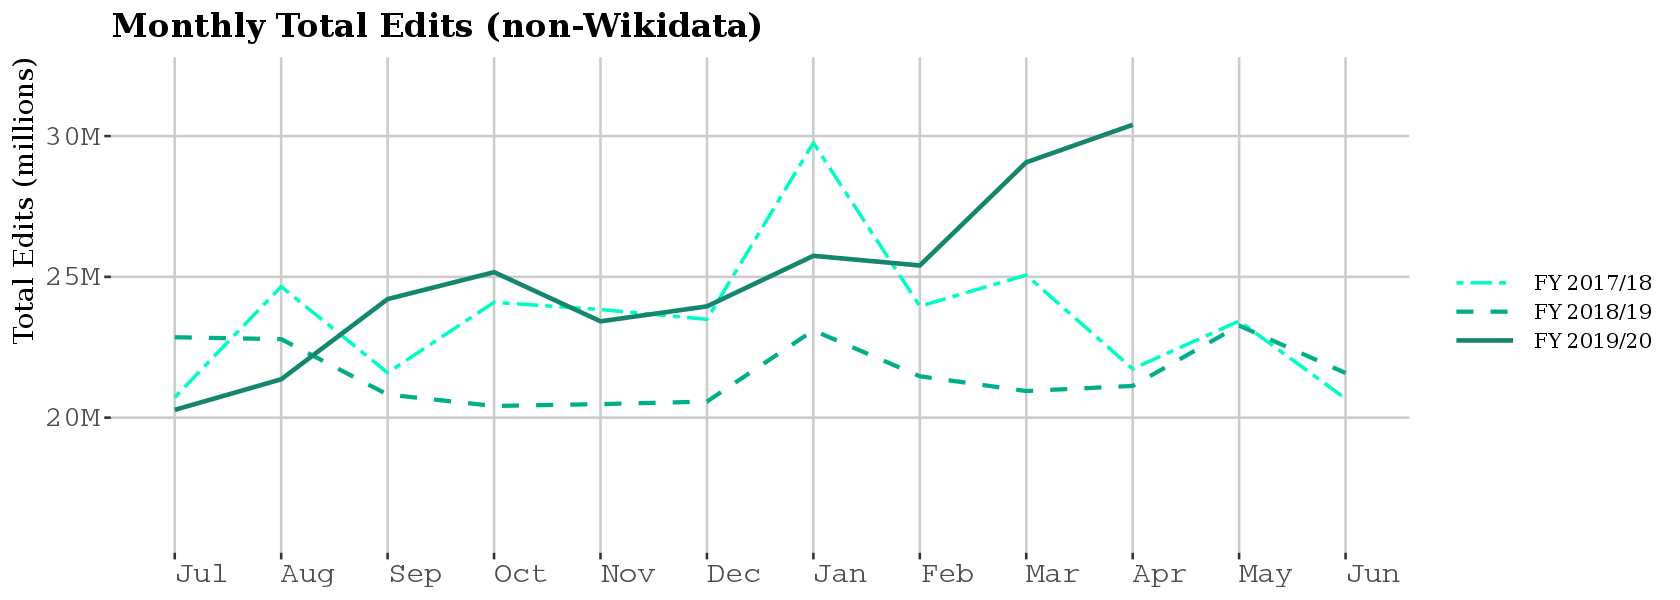

In [11]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(edit_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = nonwikidata, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=82600 , size = 4, color = '#2a4b8d') +
    #geom_text(aes(x =01, y=84000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#00fcc5", "FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = edit_fy$MonthN, labels = edit_fy$Month) +
    scale_y_continuous("Total Edits (millions)", labels = polloi::compress,limits = c(16E6, 32E6)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Total Edits (non-Wikidata)") 

p1



In [12]:
edit_type <- contributor %>% 
     select(month,uploads,wikidata_edits,mobile_edits) %>%
     filter(month >= '2016-07-01') 

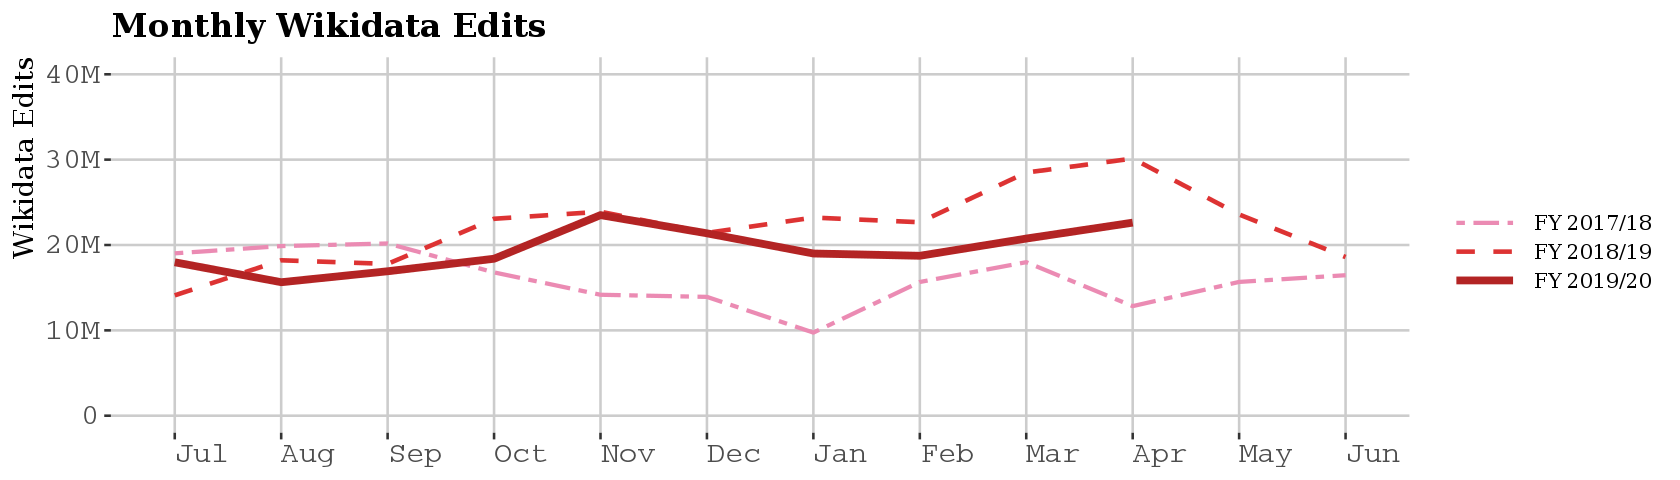

In [13]:
options(repr.plot.width = 14, repr.plot.height = 4)

p1 <- ggplot(edit_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = wikidata_edits, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#eb8bb3", "FY 2018/19" = "#dd3333","FY 2019/20" = "#b32424")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = edit_fy$MonthN, labels = edit_fy$Month) +
    scale_y_continuous("Wikidata Edits", labels = polloi::compress,limits = c(0, 40E6)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Wikidata Edits") 

p1

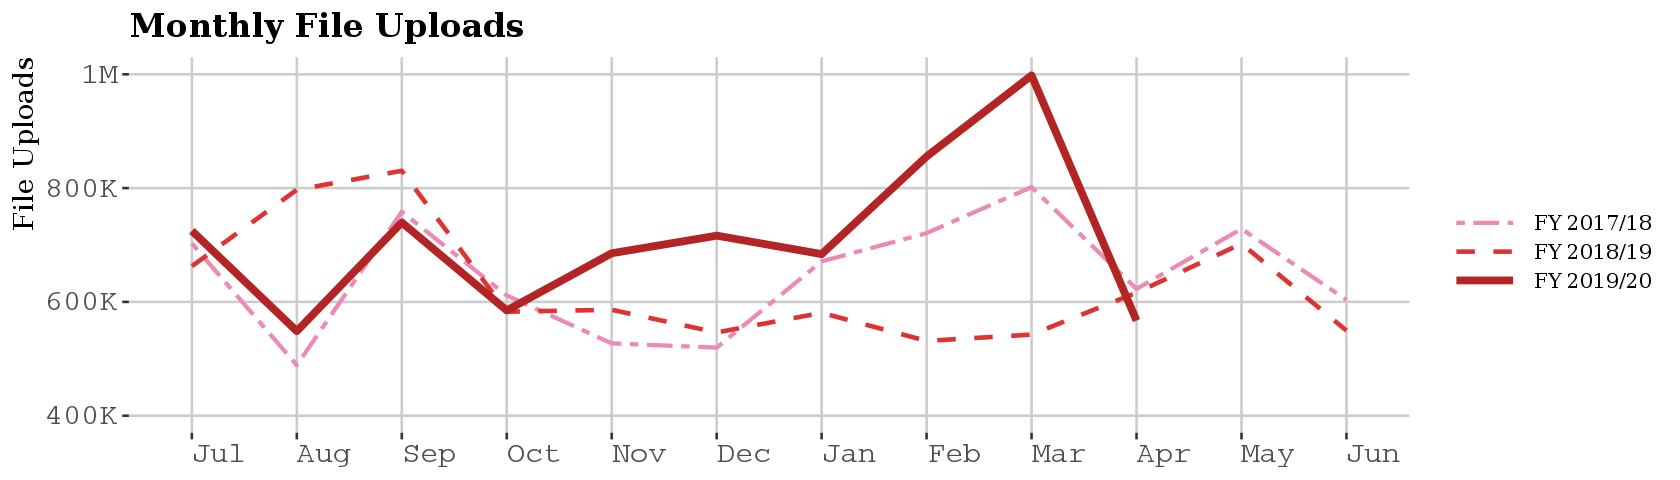

In [14]:
options(repr.plot.width = 14, repr.plot.height = 4)

p1 <- ggplot(edit_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = uploads, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=82600 , size = 4, color = '#2a4b8d') +
    #geom_text(aes(x =01, y=84000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#eb8bb3", "FY 2018/19" = "#dd3333","FY 2019/20" = "#b32424")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = edit_fy$MonthN, labels = edit_fy$Month) +
    scale_y_continuous("File Uploads", labels = polloi::compress,limits = c(40E4, 1E6)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size =10),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly File Uploads") 

p1

### Net new Content

In [15]:
content_fy <- contributor %>% 
     select(month,net_new_content_pages,net_new_Commons_content_pages,net_new_Wikidata_entities,net_new_Wikipedia_articles) %>%
     mutate(without_wikidata = net_new_content_pages - net_new_Wikidata_entities ) %>%
     filter(month >= '2017-07-01') %>%
    # filter(month < '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2017-07-01' & month < '2018-07-01', 'FY 2017/18', ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20')),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

content_fy$MonthN = factor(content_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

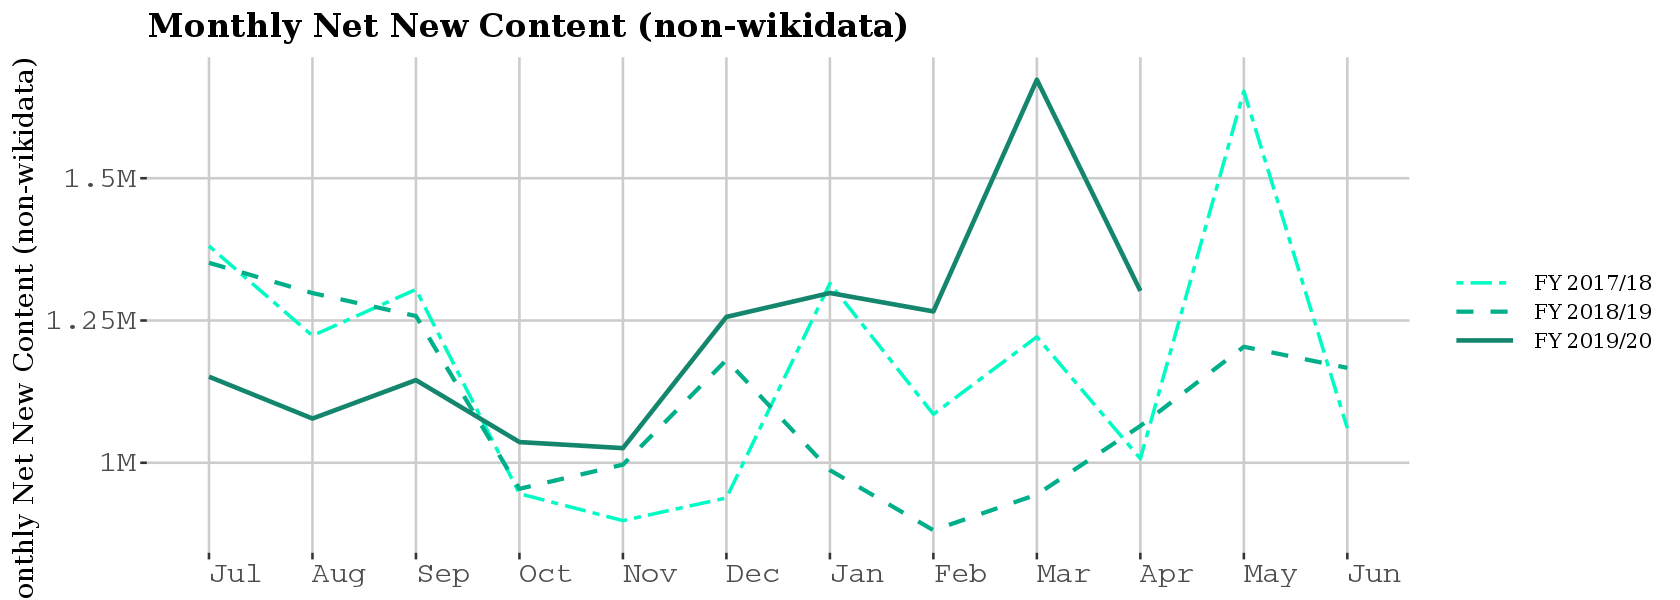

In [16]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(content_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = without_wikidata, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=82600 , size = 4, color = '#2a4b8d') +
    #geom_text(aes(x =01, y=84000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#00fcc5", "FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net New Content (non-wikidata)", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size =10),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net New Content (non-wikidata)") 

p1

#ggsave(filename="Monthly Active Editors.png", plot = p1, path = 'Figures', units = "in", dpi = 192, height = 2, width = 14, limitsize = FALSE)  


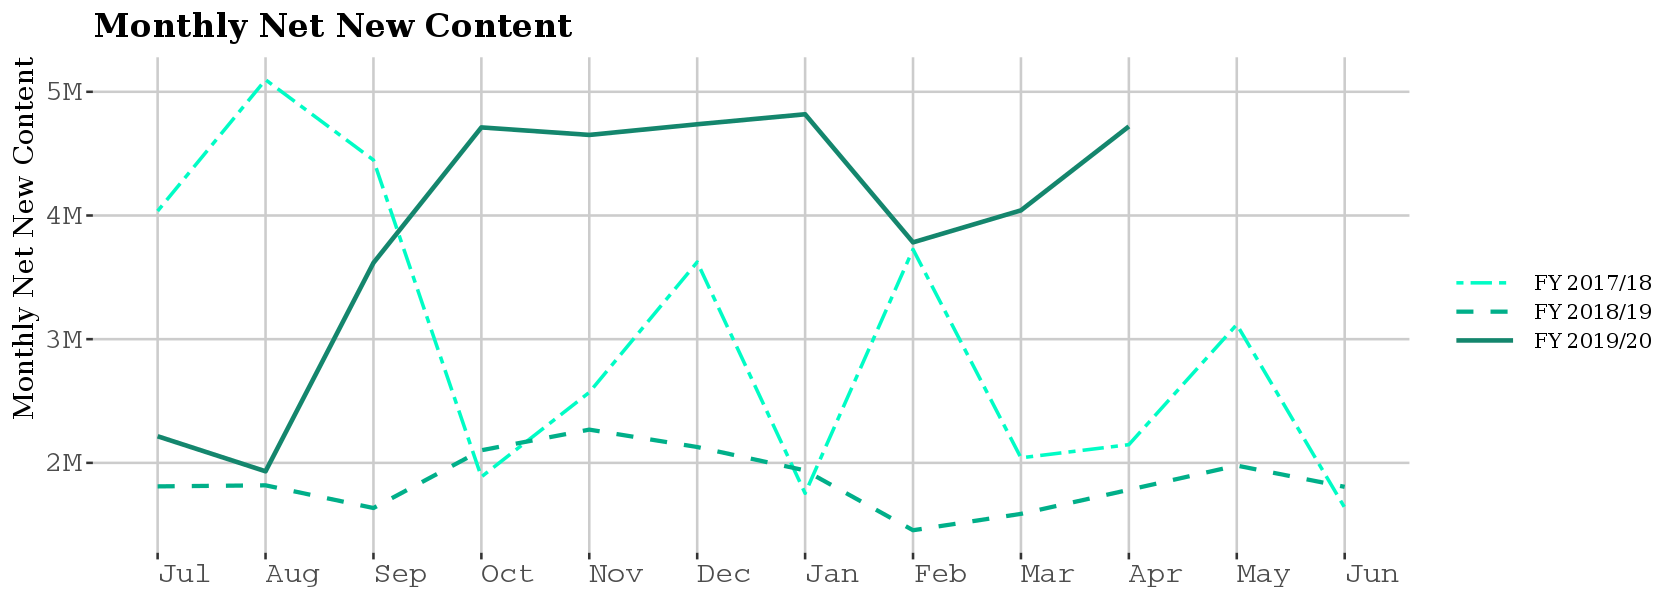

In [17]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(content_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = net_new_content_pages, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=82600 , size = 4, color = '#2a4b8d') +
    #geom_text(aes(x =01, y=84000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#00fcc5", "FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net New Content", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size =10),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net New Content") 

p1

#ggsave(filename="Monthly Active Editors.png", plot = p1, path = 'Figures', units = "in", dpi = 192, height = 2, width = 14, limitsize = FALSE)  


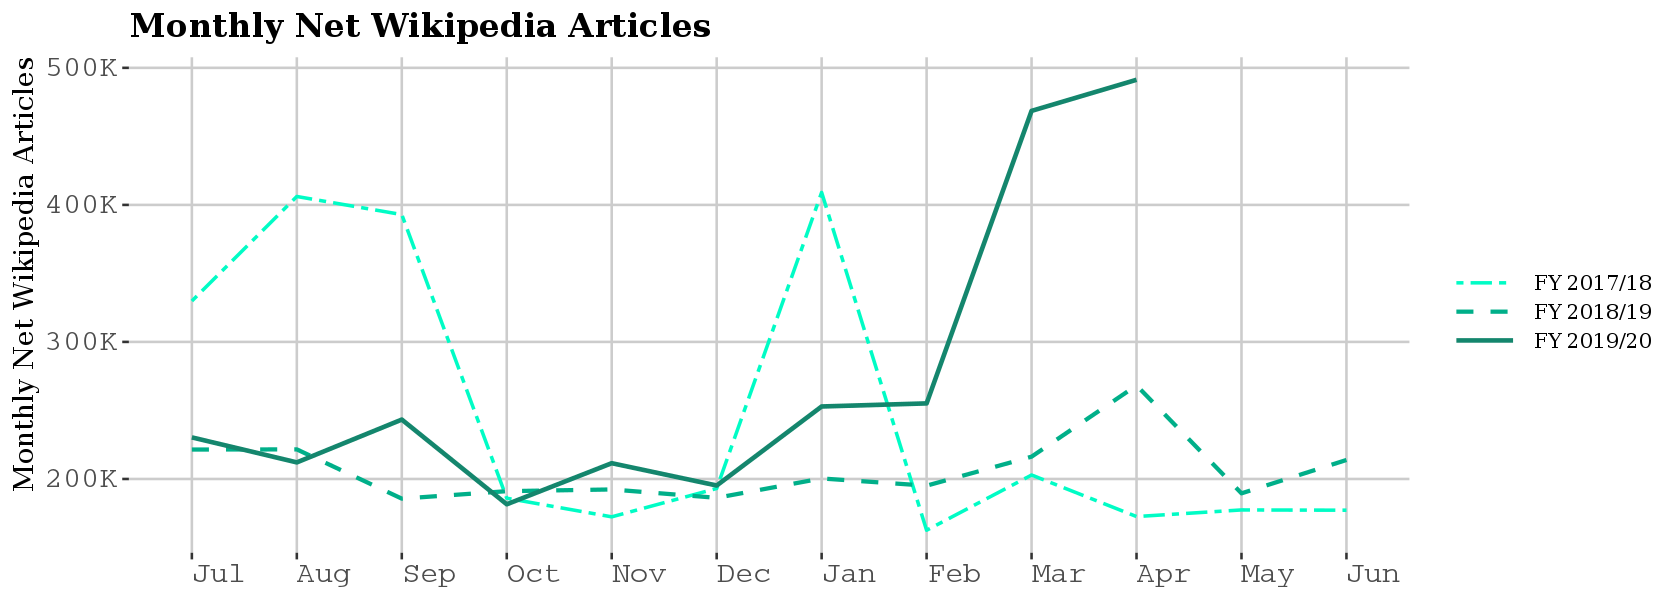

In [18]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(content_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = net_new_Wikipedia_articles, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=82600 , size = 4, color = '#2a4b8d') +
    #geom_text(aes(x =01, y=84000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#00fcc5", "FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net Wikipedia Articles", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size =10),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net Wikipedia Articles") 

p1

#ggsave(filename="Monthly Active Editors.png", plot = p1, path = 'Figures', units = "in", dpi = 192, height = 2, width = 14, limitsize = FALSE)  


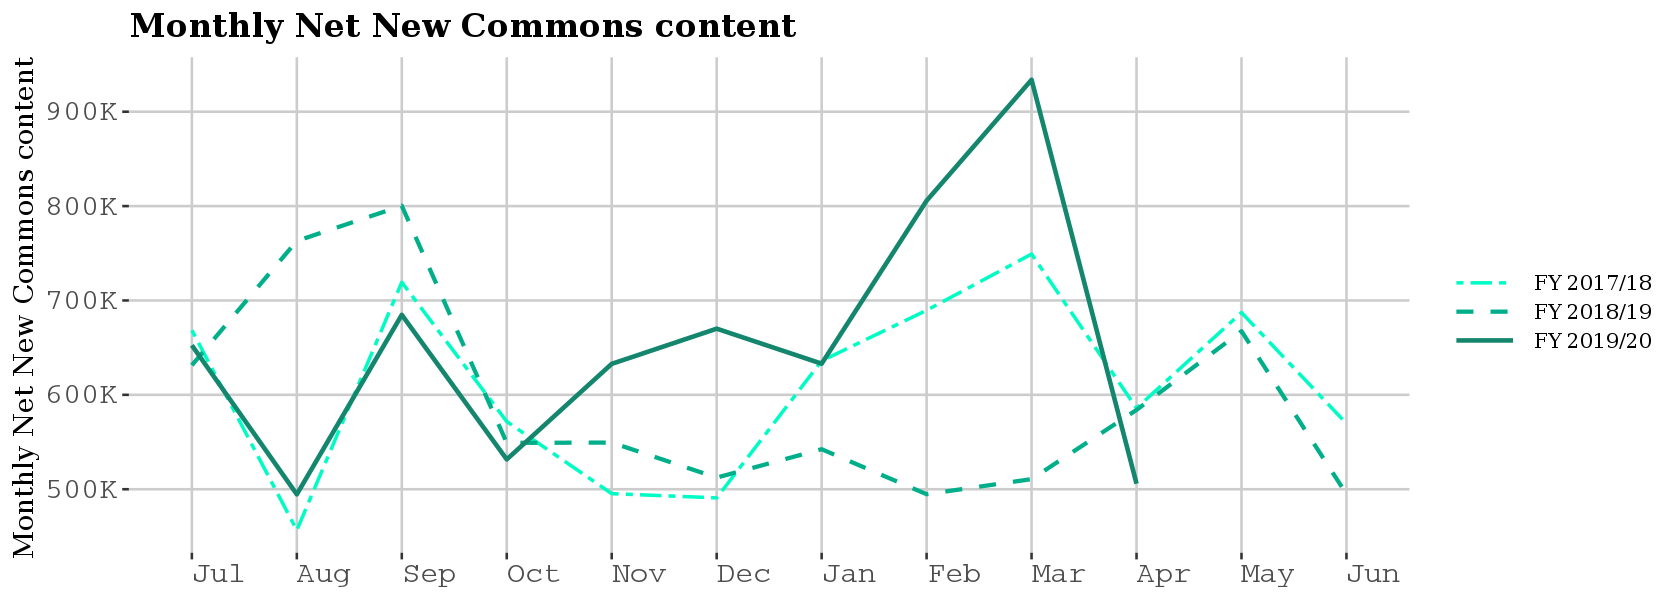

In [19]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(content_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = net_new_Commons_content_pages, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    #geom_point(x=01, y=82600 , size = 4, color = '#2a4b8d') +
    #geom_text(aes(x =01, y=84000, label="July 2019"),hjust=0, vjust=0, size= 5) +  
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#00fcc5", "FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net New Commons content", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          #legend.position = c(0.1, 0.8), legend.title = element_blank(),legend.text =element_text( hjust = 0,size =10),
          #legend.background = element_rect(fill="grey90",size=0.8,linetype="solid"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net New Commons content") 

p1

#ggsave(filename="Monthly Active Editors.png", plot = p1, path = 'Figures', units = "in", dpi = 192, height = 2, width = 14, limitsize = FALSE)  


In [9]:
retention_fy <- contributor %>% 
     select(month,new_editor_retention) %>%
      filter(month >= '2017-07-01') %>%
    # filter(month < '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2017-07-01' & month < '2018-07-01', 'FY 2017/18', ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20')),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

retention_fy$MonthN = factor(retention_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))



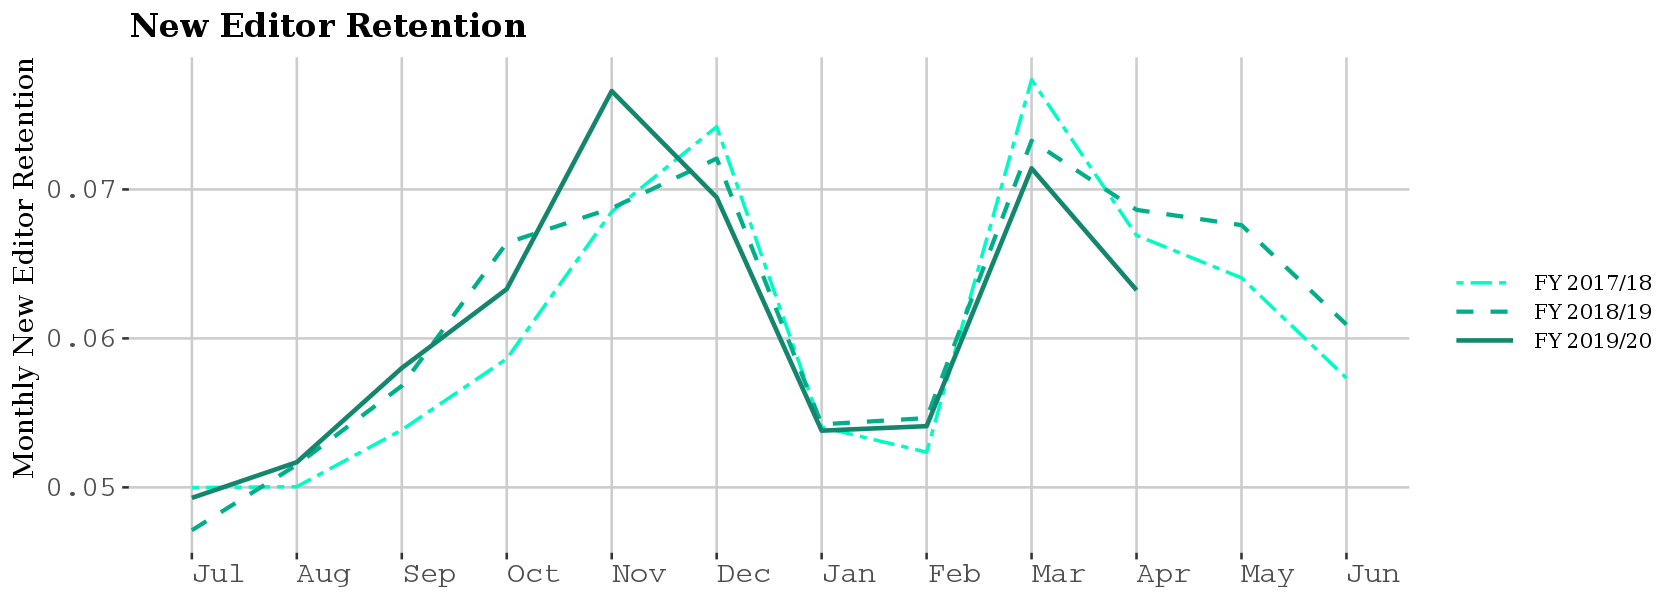

In [12]:

options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(retention_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = new_editor_retention, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2017/18" = "#00fcc5", "FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = retention_fy$MonthN, labels = retention_fy$Month) +
    scale_y_continuous("Monthly New Editor Retention", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "New Editor Retention") 

p1

## Anoy edits testing

In [13]:
anoy <- read.csv("20200520_080258.csv")

In [14]:
anoy$month = as.Date(substr(anoy$X__timestamp,0,10))

In [16]:
head(anoy_fy)

,month,sum_edit_count,user_is_anonymous,fiscal_year,MonthN,Month,anoy_user
,<date>,<dbl>,<fct>,<chr>,<fct>,<chr>,<chr>
1,2017-07-01,37681278,false,FY 2017/18,07,Jul,non-anonymous
2,2017-07-01,2087014,true,FY 2017/18,07,Jul,anonymous
3,2017-08-01,42418602,false,FY 2017/18,08,Aug,non-anonymous
4,2017-08-01,2128375,true,FY 2017/18,08,Aug,anonymous
5,2017-09-01,39718275,false,FY 2017/18,09,Sep,non-anonymous
6,2017-09-01,2070279,true,FY 2017/18,09,Sep,anonymous


In [21]:
anoy_fy <- anoy%>% 
     select(month,sum_edit_count,user_is_anonymous) %>%
     filter(month >= '2018-07-01') %>%
     mutate(fiscal_year = ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20'),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE),
         anoy_user= ifelse(user_is_anonymous == 'true','anonymous','non-anonymous'))
anoy_fy$MonthN = factor(anoy_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))



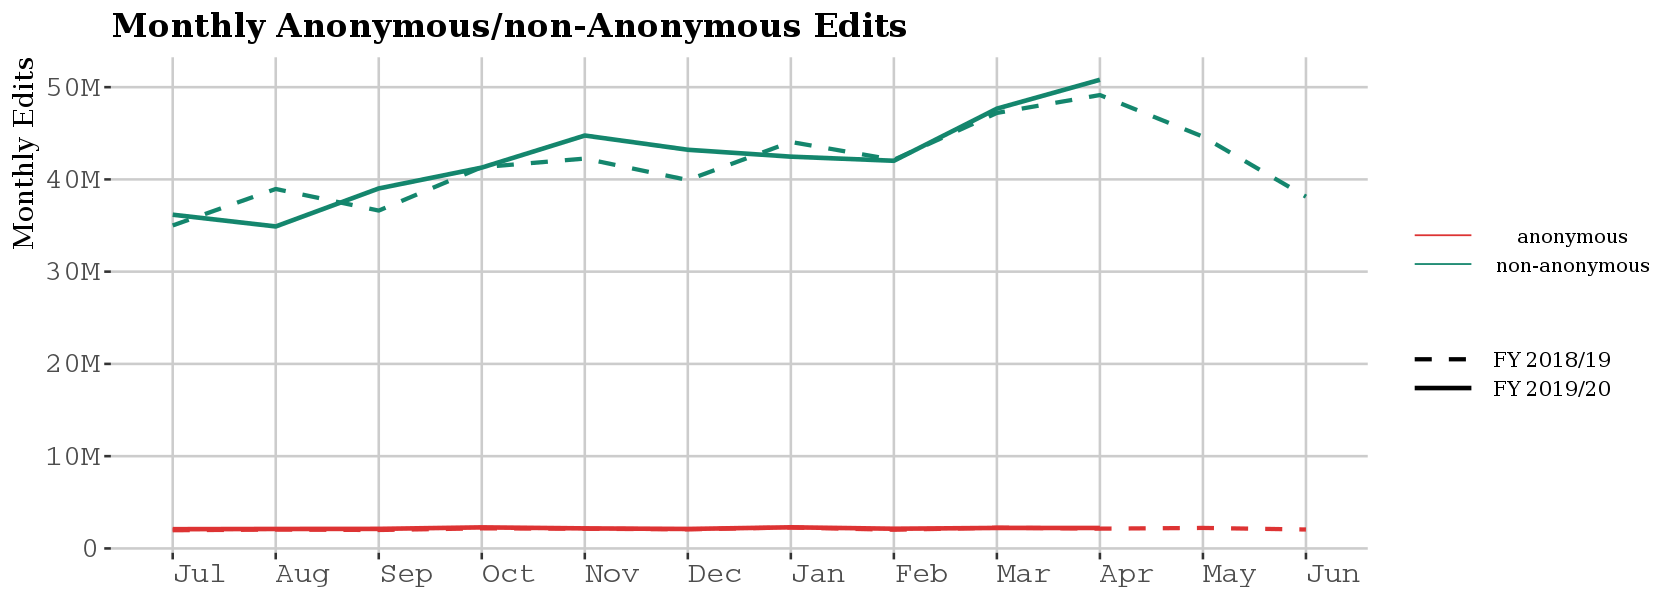

In [22]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(anoy_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = sum_edit_count, group=interaction(fiscal_year,anoy_user), color = anoy_user,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1.2,1.3)) +
    scale_color_manual(values = c( "anonymous" = "#dd3333","non-anonymous" = "#14866d")) +
    scale_linetype_manual(values=c( "dashed","solid")) +
    scale_x_discrete(breaks =anoy_fy$MonthN, labels = anoy_fy$Month) +
    scale_y_continuous("Monthly Edits", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Anonymous/non-Anonymous Edits") 

p1

In [23]:
anoy_fy <- anoy%>% 
     select(month,sum_edit_count,user_is_anonymous) %>%
          filter(month >= '2018-07-01') %>%
     mutate(fiscal_year = ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20'),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))
anoy_fy$MonthN = factor(anoy_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))



In [24]:
anoy_fy_t <- anoy_fy %>% filter(user_is_anonymous=='true')
anoy_fy_f <- anoy_fy %>% filter(user_is_anonymous=='false')

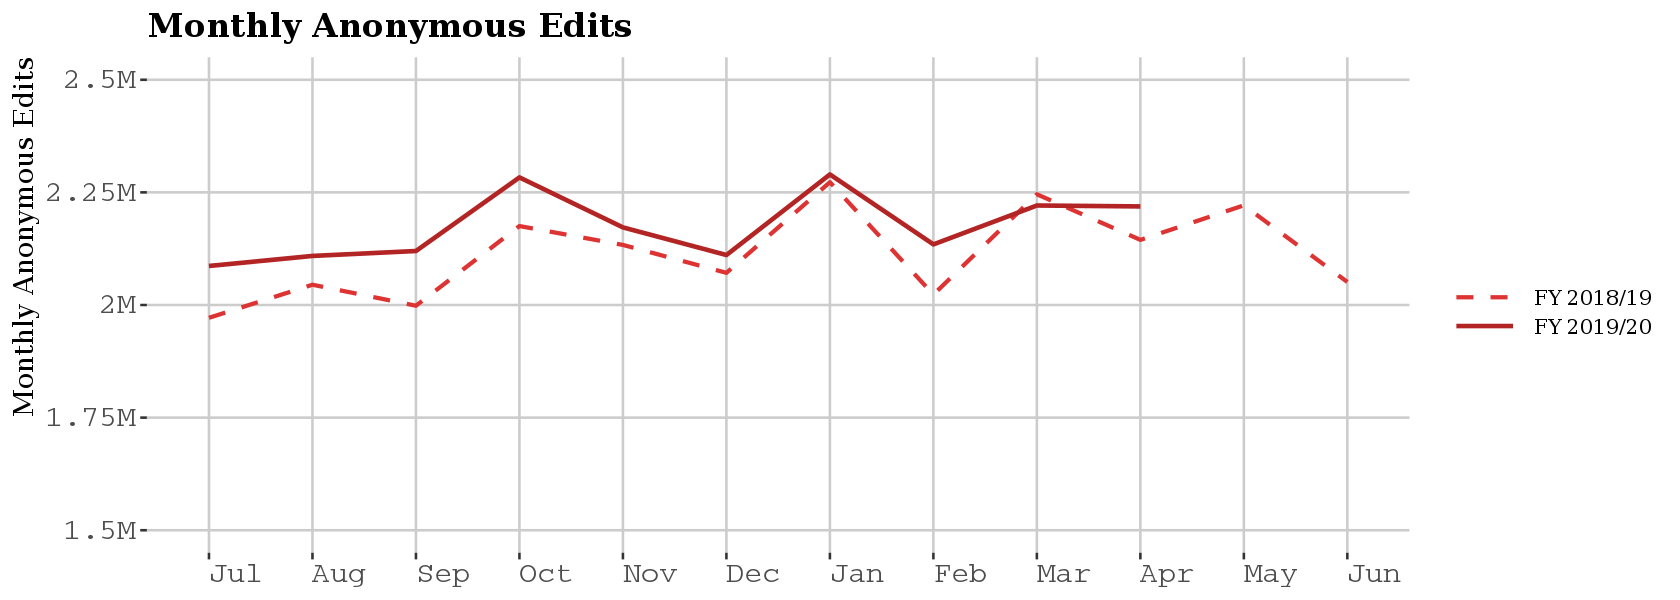

In [26]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(anoy_fy_t,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = sum_edit_count, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1.2,1.3)) +
    scale_color_manual(values = c("FY 2018/19" = "#dd3333","FY 2019/20" = "#b32424")) +
    scale_linetype_manual(values=c("dashed","solid")) +
    scale_x_discrete(breaks = anoy_fy_t$MonthN, labels = anoy_fy_t$Month) +
    scale_y_continuous("Monthly Anonymous Edits", labels = polloi::compress,limits = c(1.5E6, 2.5E6)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Anonymous Edits") 

p1

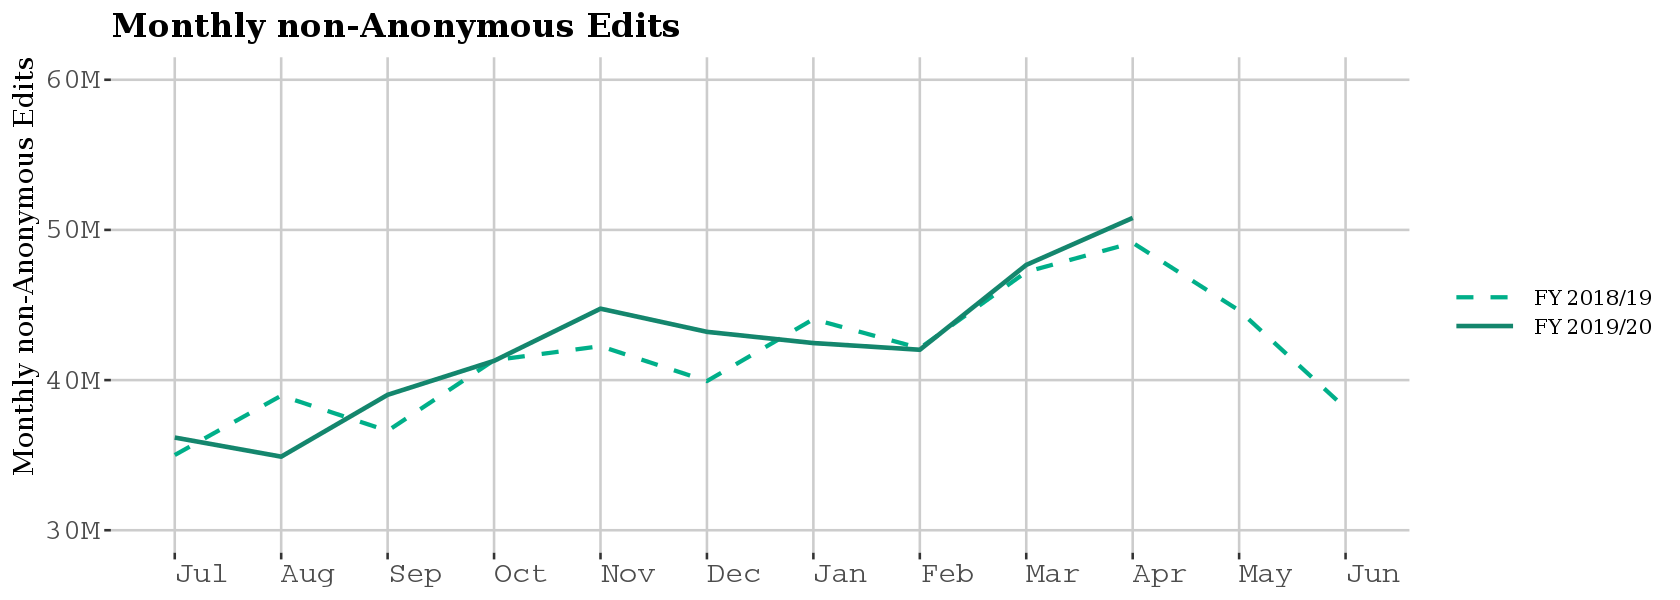

In [28]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(anoy_fy_f,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = sum_edit_count, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1.2,1.3)) +
    scale_color_manual(values = c("FY 2018/19" = "#00af89","FY 2019/20" = "#14866d")) +
    scale_linetype_manual(values=c("dashed","solid")) +
    scale_x_discrete(breaks = anoy_fy_f$MonthN, labels = anoy_fy_f$Month) +
    scale_y_continuous("Monthly non-Anonymous Edits", labels = polloi::compress,limits = c(3E7, 6E7)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text=element_text( hjust = 0,size = 18,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly non-Anonymous Edits") 

p1